In [1]:
from scipy.optimize import fsolve
from casadi import *
import matplotlib.pyplot as plt

def model(x, u, sigma, xs=None, us=None):
    '''Compute the right-hand side of the ODEs

    Args:
        x (array-like): State vector, x, y, theta, phi, v, e_dis, e_theta, e_phi, e_v
        u (array-like): Input vector, u_phi, u_v
        sigma (array-like): Parameters, L, tau_phi, tau_v
        xs (array-like, optional): steady-state
        us (array-like, optional): steady-state input

    Returns:
        array-like: dx/dt    
    '''
    if xs is not None:
        # Assume x is in deviation variable form
        x = [x[i] + xs[i] for i in range(5)]

    if us is not None:
        # Assume u is in deviation variable form
        u = [u[i] + us[i] for i in range(2)]

    dxdt = [0.] * 5
    dxdt[0] = x[4]*cos(x[2])
    dxdt[1] = x[4]*sin(x[2])
    dxdt[2] = x[4]*tan(x[3])/sigma[0]
    dxdt[3] = -1/sigma[1]*x[3]+1/sigma[1]*u[0]
    dxdt[4] = -1/sigma[2]*x[4]+1/sigma[2]*u[1]
    return dxdt

sigma = [2, 2.5, 2.5] # L, tau_phi, tau_v
us = np.array([0,0])
f = lambda x: model(x, us, sigma)
# Get the steady-state
x0 = 0
y0 = 0
xs, _, flag, _ = fsolve(f, [x0, y0, pi/4, 0, 0.5], full_output=True)

print(f'xs = {xs}')
print(f'Exit flag: {flag}')

# Parameters 
N = 300 # No. of waypoints
M = 25 # Receding Horizon
dt = 0.1 # 100 ms
C = 1 # potential field cost = (C/(dis+epsilon))^pho
epsilon = 0.01
pho = 2

# CasADi works with symbolics
t = SX.sym('t', 1, 1)
x = SX.sym('x', 5, 1)
u = SX.sym('u', 2, 1)
ode = vertcat(*model(x, u, sigma))
print(ode, ode.shape)
    
# Construct the integration block
f = {'x': x, 't':t, 'p':u , 'ode':ode}
Phi = integrator('Phi', 'cvodes', f, {'tf': dt})
# System Model - in general, the system model 
#  and the MPC model are different
system = Phi

# Define the decision variable and constraints
q = vertcat(*[MX.sym(f'u{i}', 2, 1) for i in range(M)])
s = vertcat(*[MX.sym(f'x{i}', 5, 1) for i in range(M+1)])
z = []
zlb = []
zub = []
constraints = []

# Create cost function
cost = 0.
ulb = list([-2/3*pi, 0])
uub = list([2/3*pi, 1])

for i in range(M):
    s_i = s[5*i:5*(i+1)]
    s_ip1 = s[5*(i+1):5*(i+2)]
    q_i = q[2*i:2*(i+1)]

    # Decision variable
    zlb += [-np.inf] * 5
    zub += [np.inf] * 5
    zlb += ulb
    zub += uub

    z.append(s_i)
    z.append(q_i)

    xt_ip1 = Phi(x0=s_i, p=q_i)['xf']
#     cost += (500*(s_i[0]-s_i[1]+1)*(s_i[0]-s_i[1]+1)+100*(s_i[2]-pi/4)*(s_i[2]-pi/4)+50*(s_i[4]-0.5)*(s_i[4]-0.5))
    cost += (500*(s_i[0]-s_i[1]+1)*(s_i[0]-s_i[1]+1)+100*(s_i[2]-pi/4)*(s_i[2]-pi/4)+100*(s_i[4]-0.5)*(s_i[4]-0.5)+
            C/((sqrt((s_i[0]-1)**2+(s_i[1]-2)**2)+epsilon)**2))
    constraints.append(xt_ip1 - s_ip1)

# s_N
z.append(s_ip1)
# cost += (500*(s_ip1[0]-s_ip1[1]+1)*(s_ip1[0]-s_ip1[1]+1)+100*(s_ip1[2]-pi/4)*(s_ip1[2]-pi/4)+50*(s_ip1[4]-0.5)*(s_ip1[4]-0.5))
cost += (500*(s_ip1[0]-s_ip1[1]+1)*(s_ip1[0]-s_ip1[1]+1)+100*(s_ip1[2]-pi/4)*(s_ip1[2]-pi/4)+100*(s_ip1[4]-0.5)*(s_ip1[4]-0.5)+
            C/((sqrt((s_ip1[0]-1)**2+(s_ip1[1]-2)**2)+epsilon)**2))
zlb += [-np.inf] * 5
zub += [np.inf] * 5


constraints = vertcat(*constraints)
variables = vertcat(*z)
print(constraints.shape)
print(variables.shape)
print(cost.shape)

# Create the optmization problem
g_bnd = np.zeros(constraints.shape[0])
nlp = {'f': cost, 'g': constraints, 'x': variables}
# print(nlp)
opt = {'print_time': 0, 'ipopt.print_level': 0, 'ipopt.acceptable_tol': 1e-4}
solver = nlpsol('solver', 'ipopt', nlp, opt)
def solve_mpc(current_state):
    '''Solve MPC provided the current state, i.e., this 
    function is u = h(x), which is the implicit control law of MPC.

    Args:
        current_state (array-like): current state

    Returns:
        tuple: current input and return status pair
    '''

    # Set the lower and upper bound of the decision variable
    # such that s0 = current_state
    for i in range(5):
        zlb[i] = current_state[i]
        zub[i] = current_state[i]
    sol_out = solver(lbx=zlb, ubx=zub, lbg=g_bnd, ubg=g_bnd)
    return (np.array(sol_out['x'][5:7]), solver.stats()['return_status'])

xs = [-2.35642309e+02  3.29895533e+02  7.85398170e-01  0.00000000e+00
  7.69536642e-34]
Exit flag: 1
@1=-0.4, @2=0.4, [(x_4*cos(x_2)), (x_4*sin(x_2)), ((x_4*tan(x_3))/2), ((@1*x_3)+(@2*u_0)), ((@1*x_4)+(@2*u_1))] (5, 1)
(125, 1)
(180, 1)
(1, 1)


In [2]:
import time
num_time_steps_sim = 150  # number of time steps in simulation

# Store the system states and control actions applied to the system
# in array
state_history = np.zeros((num_time_steps_sim+1, 5))
input_history = np.zeros((num_time_steps_sim+1, 2))

# Set current state - using deviation variables
state_history[0, :] = np.array([0.0, 0.0, pi/2, 0.0, 0.0]) # Point to the north
# state_history[0, :] = np.array([0.0, 0.0, pi/4, 0.0, 0.0]) # Point to the northeast
# state_history[0, :] = np.array([0.0, 0.0, 0.0, 0.0, 0.0]) # Point to the east
current_state = state_history[0, :]

# Time array for plotting
tm = [i*dt for i in range(num_time_steps_sim+1)]

mpc_start = time.time()
# Closed-loop simulation
for k in range(num_time_steps_sim):

    print(f'Current time: {k*dt}')
    current_control, status = solve_mpc(current_state)
    print(f'Solver status: {status}')

    # Advance the simulation one time step
    # Set current_state to be the state at the next time steps
    current_state = np.array(system(x0=current_state, p=current_control)['xf'])

    current_state = current_state.reshape((5,))
    current_control = current_control.reshape((2,))

    # Save data for plotting
    input_history[k, :] = current_control
    state_history[k+1:k+2, :] = current_state

# Save the last control one more time for plotting
input_history[-1, :] = current_control
mpc_end = time.time()

print(f'Scenarios costs time: {mpc_end-mpc_start}')

Current time: 0.0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver st

Solver status: Solved_To_Acceptable_Level
Current time: 12.9
Solver status: Solved_To_Acceptable_Level
Current time: 13.0
Solver status: Solved_To_Acceptable_Level
Current time: 13.100000000000001
Solver status: Solved_To_Acceptable_Level
Current time: 13.200000000000001
Solver status: Solved_To_Acceptable_Level
Current time: 13.3
Solver status: Solved_To_Acceptable_Level
Current time: 13.4
Solver status: Solved_To_Acceptable_Level
Current time: 13.5
Solver status: Solved_To_Acceptable_Level
Current time: 13.600000000000001
Solver status: Solved_To_Acceptable_Level
Current time: 13.700000000000001
Solver status: Solved_To_Acceptable_Level
Current time: 13.8
Solver status: Solved_To_Acceptable_Level
Current time: 13.9
Solver status: Solved_To_Acceptable_Level
Current time: 14.0
Solver status: Solved_To_Acceptable_Level
Current time: 14.100000000000001
Solver status: Solved_To_Acceptable_Level
Current time: 14.200000000000001
Solver status: Solved_To_Acceptable_Level
Current time: 14.3
S

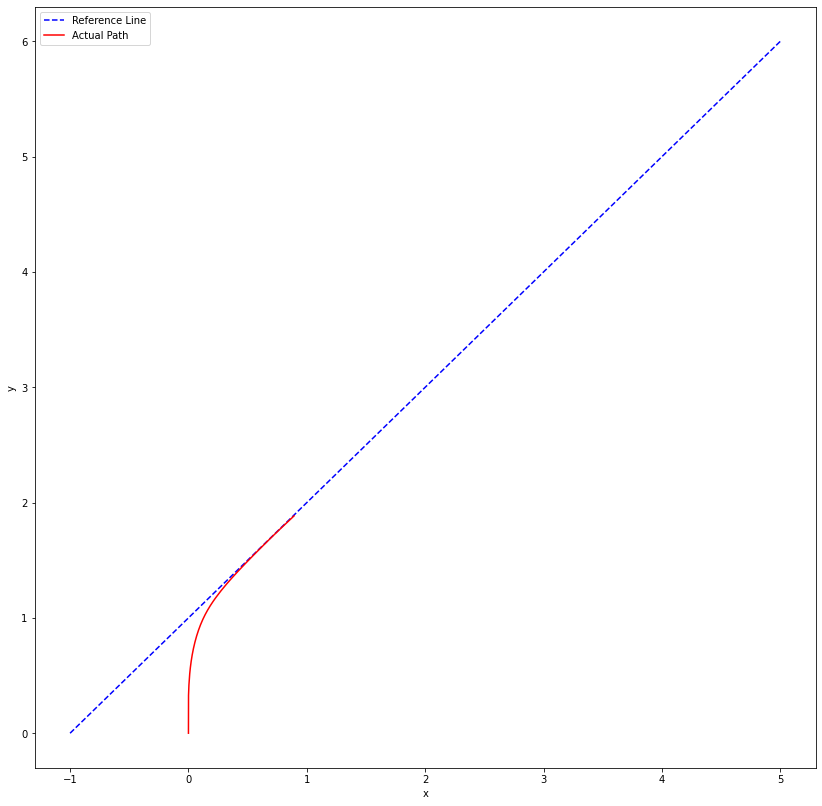

Text(0.5, 0, 'Time')

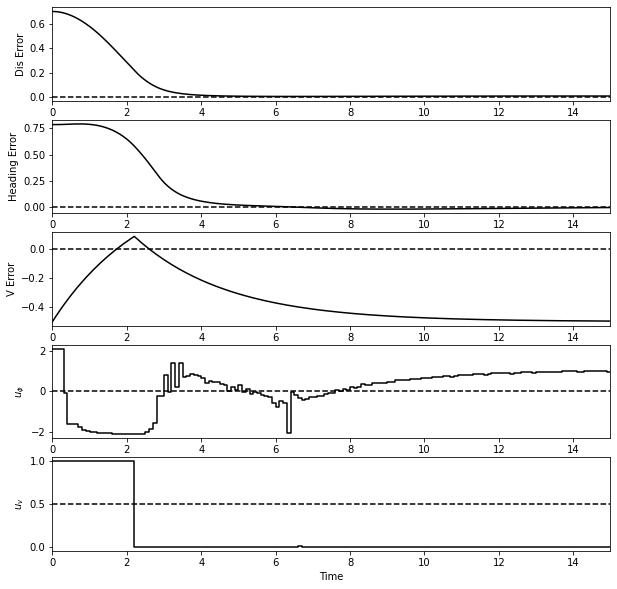

In [3]:
# print(input_history)
# print(state_history)

# Figure
plt.figure(figsize=[14, 14])
plt.plot([-1,5],[0,6], 'b--',
         state_history[:, 0], state_history[:, 1], 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(["Reference Line", "Actual Path"])
plt.show()
fig, axs = plt.subplots(5, 1, figsize=[10,10])
t_max = num_time_steps_sim*dt
# Plot errors, we care more about the distance error, heading error and speed error
axs[0].plot(tm, 1/sqrt(2)*abs(state_history[:, 0]-state_history[:, 1]+1), 'k-',
           [tm[0], tm[-1]], [0.0, 0.0], 'k--')
axs[0].set_ylabel("Dis Error")
axs[0].set_xlim(0, t_max)
axs[1].plot(tm, state_history[:, 2]-pi/4, 'k-',
           [tm[0], tm[-1]], [0.0, 0.0], 'k--')
axs[1].set_ylabel("Heading Error")
axs[1].set_xlim(0, t_max)
axs[2].plot(tm, state_history[:, 4]-0.5, 'k-',
           [tm[0], tm[-1]], [0.0, 0.0], 'k--')
axs[2].set_ylabel("V Error")
axs[2].set_xlim(0, t_max)
# Plot inputs
axs[3].step(tm, input_history[:, 0], 'k-', 
              [tm[0], tm[-1]], [0.0, 0.0], 'k--',
              where='post')
axs[3].set_ylabel(f'$u_\phi$')
axs[3].set_xlim([0, t_max])
axs[4].step(tm, input_history[:, 1], 'k-', 
              [tm[0], tm[-1]], [0.5, 0.5], 'k--',
              where='post')
axs[4].set_ylabel(f'$u_v$')
axs[4].set_xlim([0, t_max])
axs[-1].set_xlabel('Time')